In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jpholiday

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
#import ydata_profiling
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

import torch
from pytorch_lightning import Trainer
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_lightning.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("stock_price.csv")

In [4]:
def convert_volume_with_apply(volume_str):
    """
    出来高の文字列を数値に変換する関数
    """
    if pd.isna(volume_str):
        return np.nan

    volume_str = str(volume_str)

    # 右端の文字で単位を判定
    last_char = volume_str[-1]

    if last_char == 'M':  # ミリオン
        return float(volume_str[:-1]) * 1_000_000
    elif last_char == 'B':  # ビリオン
        return float(volume_str[:-1]) * 1_000_000_000
    elif last_char == 'K':  # キロ
        return float(volume_str[:-1]) * 1_000
    else:  # 単位なし
        return float(volume_str)

【データ理解　EDA】

In [4]:
df.describe()

,終値,始値,高値,安値
count,9202.000000,9202.000000,9202.000000,9202.000000
mean,92.180961,92.256183,93.176451,91.330146
std,50.452228,50.598215,51.049837,50.087405
min,33.000000,33.000000,33.200000,32.200000
25%,52.000000,52.100000,52.800000,51.500000
50%,85.100000,85.100000,86.050000,84.200000
75%,110.800000,110.800000,111.900000,109.275000
max,305.900000,309.800000,311.800000,303.900000


In [5]:
#### --> EDA用レポート表示
#ydata_profiling.ProfileReport(df)

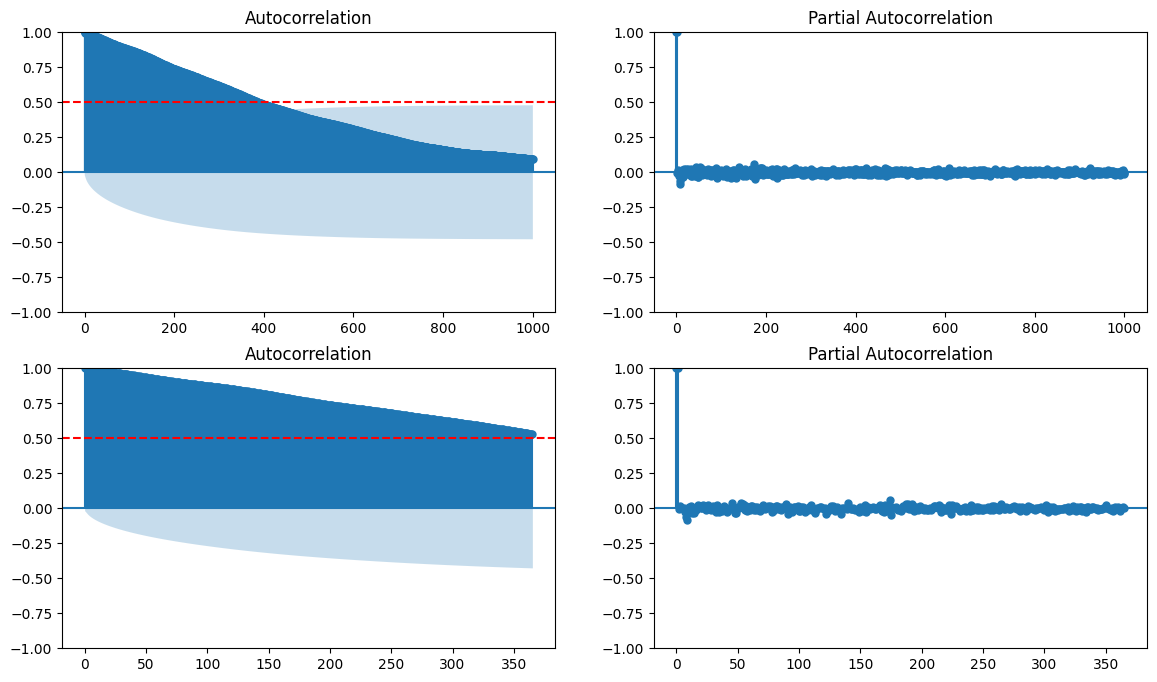

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(14,8))
plot_acf(df["終値"], ax=ax[0, 0], lags=1000)
ax[0,0].axhline(y=0.5, color='red', linestyle='--')

plot_pacf(df["終値"], ax=ax[0, 1], lags=1000)

plot_acf(df["終値"], ax=ax[1, 0], lags=365)
ax[1,0].axhline(y=0.5, color='red', linestyle='--')

plot_pacf(df["終値"], ax=ax[1, 1], lags=365)
plt.show()

【前処理と特徴量エンジニアリング】

In [5]:
#### --> 出来高列の前処理
df["出来高"].str[-1].unique()
df['出来高'] = df['出来高'].apply(convert_volume_with_apply)

#### --> 変化率列の前処理
df["変化率 %"] = df["変化率 %"].str.replace("%", "").astype(float) / 100

#### --> 日付け列の前処理
#日付け列をdatetime型に変換
df["日付け"] = pd.to_datetime(df["日付け"])
print(df.dtypes)

#日付を並び替え
df = df.sort_values("日付け", ascending=True).reset_index(drop=True)


日付け      datetime64[ns]
終値              float64
始値              float64
高値              float64
安値              float64
出来高             float64
変化率 %           float64
dtype: object


In [6]:
#### --> 日付け列の内容確認(歯抜け)
start_date = df["日付け"].min()
end_date = df["日付け"].max()
sample_dates = pd.date_range(start=start_date, end=end_date)

df_dates_set = set(df["日付け"])

# sample_datesにあるが、df_dates_setにはない日付をリスト化
missing_dates = [date for date in sample_dates if date not in df_dates_set]

# 結果を表示
if len(missing_dates) > 0:
    print(f"\n欠損の日付count : {len(missing_dates)}")
else:
    print("欠損している日付はありません。")

#
df_missing_dates = pd.DataFrame(missing_dates, columns=["欠損日"])
df_missing_dates["曜日"] = df_missing_dates["欠損日"].dt.day_name()
#土日の行に欠損があるかどうかの確認 
df_weekdays = df_missing_dates.loc[(df_missing_dates['曜日'] != 'Saturday') & (df_missing_dates['曜日'] != 'Sunday')]
#祝日の行に欠損があるかどうかの確認
df_weekdays['祝日'] = df_weekdays['欠損日'].apply(jpholiday.is_holiday)
#祝日ではない行に欠損があるかどうかの確認(81件)
df_missing = df_weekdays.loc[df_weekdays['祝日'] == False]

print(f"祝日の日付count : {len(df_weekdays)-len(df_missing)}")
print(f"単純欠損の日付count : {len(df_missing)}")


欠損の日付count : 4484
祝日の日付count : 493
単純欠損の日付count : 81


【モデルの実装】　Prophet

00:48:13 - cmdstanpy - INFO - Chain [1] start processing
00:49:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE : 6.536 %


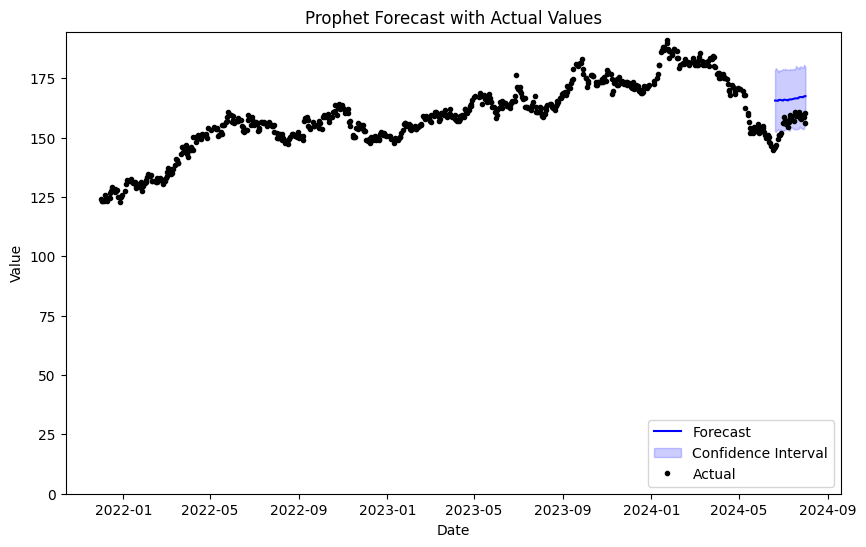

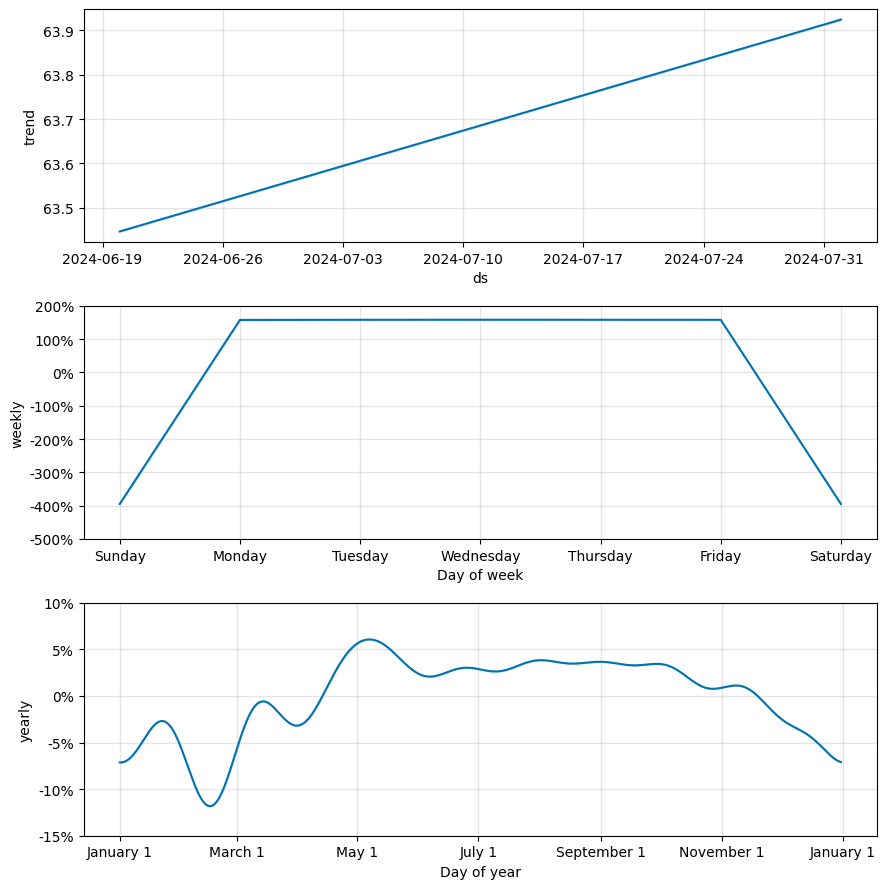

  0%|          | 0/8186 [00:00<?, ?it/s]

00:58:10 - cmdstanpy - INFO - Chain [1] start processing
00:58:36 - cmdstanpy - INFO - Chain [1] done processing
00:58:37 - cmdstanpy - INFO - Chain [1] start processing
00:59:02 - cmdstanpy - INFO - Chain [1] done processing
00:59:02 - cmdstanpy - INFO - Chain [1] start processing
00:59:26 - cmdstanpy - INFO - Chain [1] done processing
00:59:26 - cmdstanpy - INFO - Chain [1] start processing
00:59:51 - cmdstanpy - INFO - Chain [1] done processing
00:59:52 - cmdstanpy - INFO - Chain [1] start processing
01:00:14 - cmdstanpy - INFO - Chain [1] done processing
01:00:14 - cmdstanpy - INFO - Chain [1] start processing
01:00:46 - cmdstanpy - INFO - Chain [1] done processing
01:00:47 - cmdstanpy - INFO - Chain [1] start processing
01:01:11 - cmdstanpy - INFO - Chain [1] done processing
01:01:12 - cmdstanpy - INFO - Chain [1] start processing
01:01:34 - cmdstanpy - INFO - Chain [1] done processing
01:01:35 - cmdstanpy - INFO - Chain [1] start processing
01:02:03 - cmdstanpy - INFO - Chain [1]

In [ ]:
def Prophet_predictor(df:pd.DataFrame, target:str="終値",sampling_term:int=30, changepoint_prior_scale:float=0.5,seasonality_mode:str='multiplicative'):
    """
    Prophetモデルを使用して時系列データを予測する関数。

    Args:
        df (DataFrame): 予測に使用するデータフレーム。日付とターゲット変数の列を含む必要があります。
        target (str): 予測対象となる列名（例: '株価終値'）。
        sampling_term (int): 予測精度を評価するために、テストデータとして使用する期間（例: 30日間）
                             のサンプル数を指定します。
        changepoint_prior_scale (float, optional): トレンドの変化点の柔軟性を制御するパラメータ。
                                                   値が大きいほど、トレンドの急激な変化をより多く許容します。
                                                   デフォルトは0.5。
        seasonality_mode (str, optional): 季節性のモデル ('additive' または 'multiplicative') を指定します。
                                          'multiplicative'は、季節性の変動がトレンドの規模に比例して
                                          大きくなるときに適しています。
                                          デフォルトは'multiplicative'。
    
    Returns:
        なし（関数内でモデルの学習と予測を実行するため、必要に応じて変更してください）
    """
    _ = df[["日付け",target]]
    test_data = _.tail(sampling_term)
    train_data = _.rename(columns={"日付け": "ds", target: "y"}).drop(test_data.index)
    m = Prophet(changepoint_prior_scale=changepoint_prior_scale,seasonality_mode=seasonality_mode)
    m.fit(train_data)
    future = test_data[["日付け"]].rename(columns={"日付け":"ds"})
    forecast = m.predict(future)   #予測値の算出
    return m, forecast, test_data, train_data
    
def prophet_mape_evaluator(forecast:pd.DataFrame, test_data:pd.Series):
    """
    Prophetモデルの予測精度を平均絶対パーセント誤差（MAPE）で評価する関数。

    Args:
        forecast (DataFrame): Prophetモデルの予測結果を含むデータフレーム。
        actual_data (pd.Series): 実際の値を含むデータ系列。

    Returns:
        float: 計算されたMAPEの値（少数表記）。
    """
    y_pred = forecast["yhat"]
    y_test = test_data
    mape_score = mean_absolute_percentage_error(y_test,y_pred)
    print(f"MAPE : {mape_score *100:.3f} %")
    return mape_score

def plot_prophet(m, df:pd.DataFrame, forecast:pd.DataFrame, target:str="y", plotsize=(10,6), sample_start_date:str = '2021-12-01'):
    """
    Prophetの予測結果と実際の値を比較プロットする関数。

    Args:
        m : Prophetインスタンス
        df : training用dataset
        forecast (DataFrame): Prophetモデルの予測結果を含むデータフレーム。
        target (str, optional): プロット対象となる列名。デフォルトは"終値"。
        plotsize (tuple, optional): プロットのサイズを(幅, 高さ)で指定。デフォルトは(10, 6)。
        sample_start_date (str, optional): 実際の値をプロットする開始日。
                                         'YYYY-MM-DD'形式で指定。デフォルトは'2021-12-01'。

    Returns:
        tuple: プロットのFigureオブジェクトとAxesオブジェクト (fig, ax)。
    """
    # グラフを描画するaxオブジェクトを作成
    fig, ax = plt.subplots(figsize=plotsize)
    # 1. 予測値をプロット（yhatと信頼区間）
    ax.plot(forecast['ds'], forecast['yhat'], color='blue', label='Forecast')
    ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Confidence Interval')
    actual_data = df.loc[df['ds'] >= sample_start_date]
    ax.plot(actual_data['ds'], actual_data[target], 'k.', label='Actual')
    ax.set_title('Prophet Forecast with Actual Values')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend(loc='lower right')
    ax.set_ylim(0, None)
    plt.show()
    fig2 = m.plot_components(forecast)
    plt.show(fig2) 
    return fig, ax

def prophet_cv(total_rows:int = 9220, initial_days:int = 1460, period:int = 180, horizon:int = 30):
    """
    Prophetモデルに対してウォークフォワード交差検証（Cross Validation）を実行し、
    MAPEなどの評価指標を算出する関数。

    Args:
        total_rows (int): データ全体の行数（任意。内部では未使用だが、参照用に置いてある）
        initial_days (int): 学習に使用する初期データの期間（日数）。
                            例: 1460 → 最初の約4年分を学習に使う。
        period (int): 検証のステップ幅（日数）。この間隔で学習終了点をずらしながらCVを行う。
                      例: 180 → 半年ごとに予測を検証。
        horizon (int): 予測の先の期間（日数）。
                       例: 30 → 各検証で30日先まで予測して評価。

    Returns:
        DataFrame: cross_validation の結果から算出された performance_metrics（MAPE, RMSEなど）。
    """
    df_cv = cross_validation(m, initial=f'{initial_days} days', period=period, horizon=horizon)
    df_p = performance_metrics(df_cv, metrics=['mape'])     # ホライズンごとのMAPE, RMSEなどを計算
    print(df_p) # 結果の出力
    return df_p

def main():
    # === データ準備 ===
    rows = len(df)
    m, forecast, test_data, train_data = Prophet_predictor(df)　# 予測値の算出
    score = prophet_mape_evaluator(forecast, test_data["終値"]) #　評価
    plot_prophet(m, df.rename(columns={"日付け": "ds", target: "y"}), forecast, plot_size=(6,4))　# 結果の可視化
    prophet_cv(m, total_rows=rows)　# 汎化性能の検証

#メイン関数の実行
if __name__ == "__main__":
    main()


【モデルの実装】　TFT (Temporal Fusion Transformer)

In [8]:
#IDの付与
df["ID"] = "01"
df["time_idx"] = df["日付け"].factorize()[0] 
target = "終値"

# PyTorch 側で MPS デバイス確認
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

#変数定義(短期トレンドを追いかけれるように90日で定義)
pred_length = 30
max_encoder_length = 90

#学習データと検証データの分割
df_test = df.tail(pred_length)
df_train = df.drop(df.tail(pred_length).index)

df_train, df_val = train_test_split(df_train, test_size=0.2)

#学習データ作成
train = TimeSeriesDataSet(
    df_train,
    time_idx="time_idx",
    target=target,
    group_ids=["ID"],
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=pred_length,
    max_prediction_length=pred_length,
    time_varying_known_reals=["出来高", "変化率 %"],
    target_normalizer=NaNLabelEncoder(),
    allow_missing_timesteps=True 
)

#検証データ作成
val = TimeSeriesDataSet(
    df_val,
    time_idx="time_idx",
    target=target,
    group_ids=["ID"],
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=pred_length,
    max_prediction_length=pred_length,
    time_varying_known_reals=["出来高", "変化率 %"],
    target_normalizer=NaNLabelEncoder(),
    allow_missing_timesteps=True 
)

# データローダー作成
train_dataloader = train.to_dataloader(train=True, batch_size=32)
val_dataloader = val.to_dataloader(train=False, batch_size=32)

#=== モデル定義 ===
tft = TemporalFusionTransformer.from_dataset(
    train,
    hidden_size=32,
    attention_head_size=4,
    dropout=0.1,
    learning_rate=1e-3,
    loss=QuantileLoss(),
)

#=== 学習 ===
trainer = Trainer(
    max_epochs=50,
    accelerator="auto",
    devices=1,
    callbacks=[
        EarlyStopping(       # early_stopping
            monitor="val_loss",
            patience=10,     # 10エポック改善なしで停止
            mode="min"
        )
    ]
)
trainer.fit(tft, train_dataloader, val_dataloader) 

#=== 予測 ===
raw_predictions, x = tft.predict(val_dataloader, return_x=True)


cpu


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 32    
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_cont

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [21]:
predictions = tft.transform_output(raw_predictions, target_scale=x["target_scale"])
y_pred = predictions.detach().cpu().numpy()[0]
y_test = df_test.tail(30)[target].array
mape_score = mean_absolute_percentage_error(y_test,y_pred)
mape_score

3.484046417182849